# Telecom Churn | Predictive Analytics

**Objective:** Predict when a customer churns

**Background:** There are many variables in this dataset so the most important part of this process is to reduce the number of variables **to avoid overfitting** and **to avoid the curse of dimensionality**.

**Analysis Objective:** After creating, training, cross validating our model, we want our client to be able to **take action on current customers** (ex: sending specific promotional, gratituous offers etc) **to reduce churn rate**.

### Import modules

In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns

In [16]:
churn = 'churn.csv' # import data
df = pd.read_csv(churn)
df = df.iloc[:, 1:]
df = df.drop(['customerID'],axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,142,2505,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,498,1466,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,436,157,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,266,1400,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,729,925,1


## Normalize Features

In [17]:
# prep for normalizing
X = df.iloc[:,0:19].values
y = df.iloc[:,19].values

# normalize so prediction on features will be on same scale
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
dfNorm = pd.DataFrame(X_std, index=df.index, columns=df.columns[0:19])

# add target variable to dataframe
dfNorm['churn'] = df['Churn']

# prep X and y arrays
X = dfNorm.iloc[:,0:19].values
y = dfNorm.iloc[:,19].values

dfNorm.head()

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn
0,-1.009559,-0.439916,1.034530,-0.654012,-1.277445,-3.054010,0.062723,-1.183234,-0.918838,1.242550,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,0.398558,-1.131766,-0.398608,0
1,0.990532,-0.439916,-0.966622,-0.654012,0.066327,0.327438,-0.991588,-1.183234,1.407321,-1.029919,1.245111,-0.925262,-1.113495,-1.121405,0.371271,-1.205113,1.334863,-0.387740,-0.948762,0
2,0.990532,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,-0.991588,-1.183234,1.407321,1.242550,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,1.334863,-0.517317,-1.641883,1
3,0.990532,-0.439916,-0.966622,-0.654012,0.514251,-3.054010,0.062723,-1.183234,1.407321,-1.029919,1.245111,1.396299,-1.113495,-1.121405,0.371271,-1.205113,-1.474052,-0.872611,-0.983710,0
4,-1.009559,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,-0.991588,0.172250,-0.918838,-1.029919,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,0.398558,0.095041,-1.235224,1


## Create Training and Test Data

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=0)

X_train.shape, y_train.shape, X_test.shape , y_test.shape

((4930, 19), (4930,), (2113, 19), (2113,))

## Create Pipeline Functions

In [19]:
# pipeline funcion
results_test = {}
results_train = {}
def predict_churn(algo_name,X_train,y_train,X_test,y_test,verbose=0):
    algo_name.fit(X_train, y_train)
    Y_pred = algo_name.predict(X_test)
    acc_train = round(algo_name.score(X_train, y_train) * 100, 2)
    acc_val = round(algo_name.score(X_test, y_test) * 100, 2)
    results_test[str(algo_name)[0:str(algo_name).find('(')]] = acc_val
    results_train[str(algo_name)[0:str(algo_name).find('(')]] = acc_train
    if verbose ==0:
        print("acc train: " + str(acc_train))
        print("acc test: "+ str(acc_val))
    else:
        return Y_pred

In [20]:
from sklearn import metrics

# confusion matrix function
def conf_matrix(algo_name,X_test, y_test):
    y_pred = algo_name.predict(X_test)
    forest_cm = metrics.confusion_matrix(y_pred, y_test, [1,0])
    sns.heatmap(forest_cm, annot=True, fmt='.2f',xticklabels = ["1", "0"] , yticklabels = ["1", "0"] )
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.title(str(algo_name)[0:str(algo_name).find('(')])

## 1. Random Forrest Classifier

acc train: 99.66
acc test: 79.08
             precision    recall  f1-score   support

          0       0.83      0.90      0.86      1560
          1       0.63      0.49      0.55       553

avg / total       0.78      0.79      0.78      2113



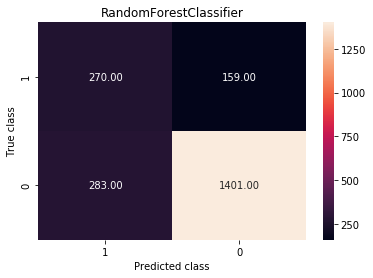

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=50, random_state=0 )
predict_churn(rf,X_train,y_train,X_test,y_test)
print(classification_report(y_test, rf.predict(X_test)))
conf_matrix(rf,X_test, y_test)


## 2. Gradient Boosting Classifier

acc train: 99.51
acc test: 78.09
             precision    recall  f1-score   support

          0       0.84      0.87      0.85      1560
          1       0.59      0.53      0.56       553

avg / total       0.77      0.78      0.78      2113



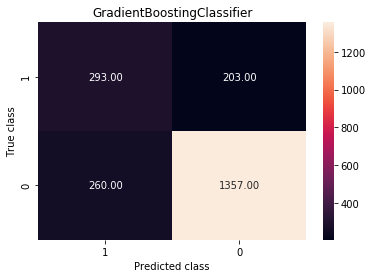

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.2, n_estimators=200 , max_depth=6)
predict_churn(gbc,X_train,y_train,X_test,y_test)

print(classification_report(y_test, gbc.predict(X_test)))
conf_matrix(gbc,X_test, y_test)

## 3. Support Vector Machine

### 3a. Linear SVM

In [23]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True)
predict_churn(svm,X_train,y_train,X_test,y_test)

acc train: 79.98
acc test: 80.03


### 3b. Linear RBF

In [24]:
svm = SVC(kernel='rbf', probability=True)
predict_churn(svm,X_train,y_train,X_test,y_test)

acc train: 82.45
acc test: 79.22


### 3c. Poly SVM

In [25]:
svm = SVC(kernel='poly', probability=True)
predict_churn(svm,X_train,y_train,X_test,y_test)

acc train: 83.45
acc test: 78.89


### Linear SVM Model

acc train: 79.98
acc test: 80.03
             precision    recall  f1-score   support

          0       0.84      0.90      0.87      1560
          1       0.65      0.52      0.58       553

avg / total       0.79      0.80      0.79      2113



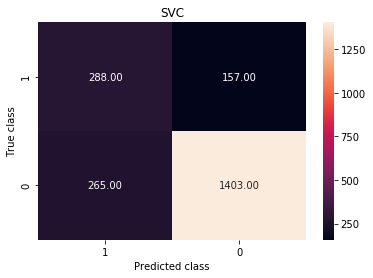

In [26]:
svm = SVC(kernel='linear', probability=True)
predict_churn(svm,X_train,y_train,X_test,y_test)

print(classification_report(y_test, svm.predict(X_test)))
conf_matrix(svm,X_test, y_test)

## Compare Models

In [27]:
df_test =pd.DataFrame(list(results_test.items()),
                      columns=['algo_name','acc_test'])
df_train =pd.DataFrame(list(results_train.items()),
                      columns=['algo_name','acc_train'])
df_results = df_test.join(df_train.set_index('algo_name'), on='algo_name')
df_results.sort_values('acc_test',ascending=False)

,algo_name,acc_test,acc_train
2,SVC,80.03,79.98
0,RandomForestClassifier,79.08,99.66
1,GradientBoostingClassifier,78.09,99.51


## Conclusion

Comparing the three models we used, we will use the Linear SVM Model for our prediction. The model has the highest accuracy with new test data which we will use to predict and take action when current customers are likely to churn.